In [1]:
from pathlib import Path
import sys
import matplotlib.pyplot as plt

home_path = str(Path.cwd().parent)
sys.path.append(home_path)

sys.path.append('/eos/home-i03/m/morwat/.local/lib/python3.9/site-packages/')

In [2]:
from aper_package.interactive_tool import InteractiveTool

In [4]:
tool = InteractiveTool()
tool.show()

Loading line from dict:   0%|          | 0/102050 [00:00<?, ?it/s]

In [55]:
import pandas as pd
import numpy as np
import tfs
df_no_nans = tool.aperture_data.aper_b1.dropna()
df_b1 = tfs.read('/eos/project-i02/c/collimation-team/machine_configurations/LHC_run3/2023/MADX/injection/aperture/ap_ir5b1.tfs')
df_b1['NAME']=df_b1['NAME'].str.lower()
df_no_nans['NAME']=df_no_nans['NAME'].str.lower()

/tmp/ipykernel_7890/3405699162.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [117]:
merged = pd.merge(df_no_nans, df_b1, on='NAME')
merged['N1x_calculated'] = (merged['APER_1_x']-merged['RTOL']-merged['XTOL']-0.002)/(np.sqrt(1.15*merged['BETX']*tool.aperture_data.epsilon+(merged['DX']**2)*(0.00031**2)))
merged['N1y_calculated'] = (merged['APER_2_x']-merged['RTOL']-merged['YTOL']-0.002)/(np.sqrt(1.15*merged['BETY']*tool.aperture_data.epsilon+(merged['DY']**2)*(0.00031**2)))

In [78]:
merged[['NAME', 'N1', 'N1x_calculated', 'N1y_calculated']].NAME.values[-1]

'mcbh.13r5.b1'

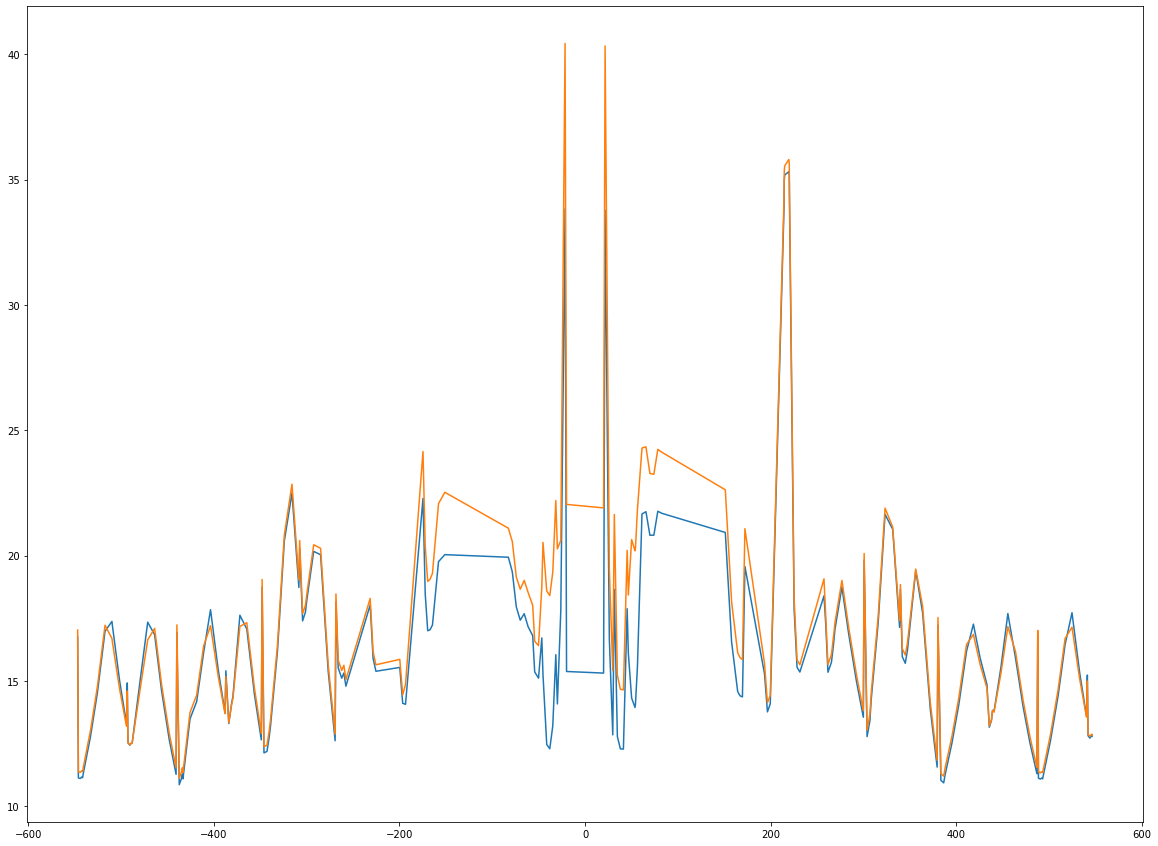

In [118]:
ip5pos = 13329.289216000001

fig,ax = plt.subplots(figsize=(20,15))
ax.plot(merged.S_x-ip5pos,merged.N1)
ax.plot(merged.S_x-ip5pos,np.min(np.array([merged.N1x_calculated.values,merged.N1y_calculated.values]),axis=0))
fig.show()

In [75]:
merged[merged.NAME.str.contains('mqxa')]

,NAME,APER_TOL_1,APER_TOL_2,APER_TOL_3,APER_1_x,APER_2_x,APER_3_x,APER_4_x,S_x,S_y,...,APER_1_y,APER_2_y,APER_3_y,APER_4_y,APER_OFFSET,RTOL,XTOL,YTOL,N1x_calculated,N1y_calculated
96,mqxa.3l5,0.0006,0.0,0.0,0.02890,0.02400,0.02890,0.02890,13279.139216,13279.13922,...,0.02890,0.02400,0.02890,0.02890,0.0,0.0006,0.00048,0.00075,25.517698,16.059309
104,mqxa.1l5,0.0006,0.0,0.0,0.02385,0.01895,0.02385,0.02385,13303.139216,13303.13922,...,0.02385,0.01895,0.02385,0.02385,0.0,0.0006,0.00015,0.00093,25.345505,20.167791
109,mqxa.1r5,0.0006,0.0,0.0,0.02385,0.01895,0.02385,0.02385,13355.439216,13355.43922,...,0.02385,0.01895,0.02385,0.02385,0.0,0.0006,0.00036,0.00048,27.203305,19.044766
117,mqxa.3r5,0.0006,0.0,0.0,0.02890,0.02400,0.02890,0.02890,13379.439216,13379.43922,...,0.02890,0.02400,0.02890,0.02890,0.0,0.0006,0.00027,0.00058,20.187211,20.577650


In [76]:
(13303.139216+13355.439216)/2

13329.289216000001

In [126]:
merged.iloc[-1]

NAME              mcbh.13r5.b1
APER_TOL_1             0.00084
APER_TOL_2             0.00036
APER_TOL_3                 0.0
APER_1_x                 0.022
APER_2_x               0.01715
APER_3_x                 0.022
APER_4_x                 0.022
S_x               13875.729841
S_y                13875.72984
BETX                172.628115
BETY                 32.904717
DX                    2.131862
DY                     0.00996
X                    -0.000011
Y                         -0.0
N1                   12.792754
APERTYPE           RECTELLIPSE
APER_1_y                 0.022
APER_2_y               0.01715
APER_3_y                 0.022
APER_4_y                 0.022
APER_OFFSET                0.0
RTOL                   0.00145
XTOL                    0.0009
YTOL                       0.0
N1x_calculated       12.853754
N1y_calculated       26.070084
Name: 218, dtype: object

In [124]:
def calcaper(ele,df,rtol=1,xtol=1,dp=0.00086,betabeat=1.2,parasitic=True,dpara=0.14,fdqf=2.086,betaarc=170.25):
    row = df[df.NAME==ele]
    dx0 = row['DX']
    dy0 = row['DY']
    if parasitic:
        dx = dx0*(np.sqrt(betabeat)-1) + (betabeat*np.sqrt(row['BETX'])*fdqf*dpara)/np.sqrt(betaarc)
        dy = dy0*(np.sqrt(betabeat)-1) + (betabeat*np.sqrt(row['BETY'])*fdqf*dpara)/np.sqrt(betaarc)
    else:
        dx, dy = dx0, dy0
    aperx = (row['APER_1_x']-rtol*row['RTOL']-xtol*row['XTOL']-0.002)/(np.sqrt(betabeat*row['BETX']*tool.aperture_data.epsilon+(dx*dp)**2))
    apery = (row['APER_2_x']-rtol*row['RTOL']-xtol*row['YTOL']-0.002)/(np.sqrt(betabeat*row['BETY']*tool.aperture_data.epsilon+(dy*dp)**2))
    print([ele,aperx.values[0],apery.values[0],row['N1'].values[0],row['APER_1_x'].values[0],row['RTOL'].values[0],row['XTOL'].values[0],row['BETX'].values[0],row['DX'].values[0]])

In [125]:
calcaper('mcbh.13r5.b1',merged)
calcaper('mcbh.13r5.b1',merged,rtol=0)
calcaper('mcbh.13r5.b1',merged,xtol=0)
calcaper('mcbh.13r5.b1',merged,dp=3.1e-4)

['mcbh.13r5.b1', 13.377821202979542, 24.769185402065293, 12.79275391, 0.022, 0.00145, 0.0009, 172.6281152, 2.131861743]
['mcbh.13r5.b1', 14.476849007190324, 27.390741521261983, 12.79275391, 0.022, 0.00145, 0.0009, 172.6281152, 2.131861743]
['mcbh.13r5.b1', 14.059976391800026, 24.769185402065293, 12.79275391, 0.022, 0.00145, 0.0009, 172.6281152, 2.131861743]
['mcbh.13r5.b1', 14.2158996133863, 25.4199624758762, 12.79275391, 0.022, 0.00145, 0.0009, 172.6281152, 2.131861743]


In [122]:
calcaper('mcbh.13r5.b1',merged,betabeat=1.15)
calcaper('mcbh.13r5.b1',merged,betabeat=1.15,)

['mcbh.13r5.b1', 13.832439672533608, 12.79275391, 0.022, 0.00145, 0.0009, 172.6281152, 2.131861743]
['mcbh.13r5.b1', 14.537776539688295, 12.79275391, 0.022, 0.00145, 0.0009, 172.6281152, 2.131861743]


In [113]:
tool.aperture_data.epsilon

7.297687659909227e-09

In [114]:
3.5e-6*0.938/450

7.295555555555555e-09

In [10]:
import plotly.graph_objects as go
def add_velo(data: object) -> go.Scatter:
    """
    Add a VELO trace at the IP8 position.

    Parameters:
        data: An ApertureData object containing twiss data for beam 1.

    Returns:
        go.Scatter: A Plotly scatter trace representing the VELO.
    """

    # Find ip8 position
    ip8 = data.tw_b1.loc[data.tw_b1['name'] == 'ip8', 's'].values[0]

    # VELO position
    x0=ip8-0.2
    x1=ip8+0.8
    y0=-0.05
    y1=0.05

    trace = go.Scatter(x=[x0, x0, x1, x1], y=[y0, y1, y1, y0], mode='lines', line=dict(color='green'), name='VELO')

    return trace


In [38]:
# VELO position
ip8=23315.30277
x0=ip8-0.2
x1=ip8+0.8
y0=-0.05
y1=0.05
velo = go.Scatter(
    x=[x0, x0, x1, x1],  # x-coordinates
    y=[y0, y1, y1, y0],  # y-coordinates
    mode='lines',  # Line mode to draw the borders
    line=dict(color='green'),  # Green line for the border
    name='VELO'
)

In [48]:
tool.update_graph()

In [49]:
tool.fig_widget.add_trace(velo)
# Add a horizontal dashed gray line at y=12

tool.fig_widget.add_shape(
    type="line",
    x0=ip8, x1=ip8,  # from x=0 to x=5 (full width of the plot)
    y0=-0.5, y1=0.5,  # horizontal line at y=12
    line=dict(
        color="gray",
        width=1,
        dash="dash",  # sets the line style to dashed
    ),
)

tool.fig_widget.update_layout(showlegend=True)

FigureWidget({
    'data': [{'line': {'color': 'gray'},
              'mode': 'lines',
              'name': 'Aperture b1',
              'text': array(['vc1ax.1r1.a.b1', 'vc1tb.1r1.a.b1', 'vc1tb.1r1.b.b1', ...,
                             'vc1tb.1l1.c.b1', 'vc1tb.1l1.d.b1', 'vc1ax.1l1.b.b1'], dtype=object),
              'type': 'scatter',
              'uid': '207b7519-8191-4a8f-894b-e934fd68ecbf',
              'x': array([4.54000000e+00, 9.00000000e+00, 1.04461450e+01, ..., 2.66484370e+04,
                          2.66498832e+04, 2.66543432e+04]),
              'xaxis': 'x',
              'y': array([0.029, 0.029, 0.029, ..., 0.029, 0.029, 0.029]),
              'yaxis': 'y'},
             {'line': {'color': 'gray'},
              'mode': 'lines',
              'name': 'Aperture b1',
              'text': array(['vc1ax.1r1.a.b1', 'vc1tb.1r1.a.b1', 'vc1tb.1r1.b.b1', ...,
                             'vc1tb.1l1.c.b1', 'vc1tb.1l1.d.b1', 'vc1ax.1l1.b.b1'], dtype=object),
            

In [6]:
import numpy as np
def fun(a, b):
    return np.sqrt(a**2+b**2)

In [13]:
fun(4, 4-1)

5.0